<a href="https://colab.research.google.com/github/so-907/Sentiment-Analysis-on-Recipe-Reviews/blob/main/Recipe_Reviews_and_User_Feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

# Caricamento dei dati

In [ ]:
# fetch dataset
recipe_reviews_and_user_feedback = fetch_ucirepo(id=911)

# data (as pandas dataframes)
df = recipe_reviews_and_user_feedback.data.original
df.head(5)

,num_records,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because of onion haters in my house, used Italian seasoning instead of just oregano, and use a paprika/ cayenne mix and a little more than the recipe called for.. we like everything a bit more hot. The chili was amazing! It was easy to make and everyone absolutely loved it. It will now be a staple meal in our house."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,"Bush used to have a white chili bean and it made this recipe super simple. I’ve written to them and asked them to please!, bring them back"
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,"I have a very complicated white chicken chili recipe that I have made for years. Everyone raves over it. I saw this recipe and thought I’d try it as an easy alternative for weeknights. My husband likes this recipe better! Super easy and delicious! I did cut back slightly on the crushed oregano and cayenne pepper, otherwise I made it exactly as written."
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream cheese but there is none listed in the ingredients!"
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#34; night dinner at our church and everyone wanted the recipe. We make it quite often at home and it&#39;s always a hit. I also use a freshly made rotisserie chicken which adds to the flavor.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18182 entries, 0 to 18181
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   num_records      18182 non-null  int64 
 1   recipe_number    18182 non-null  int64 
 2   recipe_code      18182 non-null  int64 
 3   recipe_name      18182 non-null  object
 4   comment_id       18182 non-null  object
 5   user_id          18182 non-null  object
 6   user_name        18182 non-null  object
 7   user_reputation  18182 non-null  int64 
 8   created_at       18182 non-null  int64 
 9   reply_count      18182 non-null  int64 
 10  thumbs_up        18182 non-null  int64 
 11  thumbs_down      18182 non-null  int64 
 12  stars            18182 non-null  int64 
 13  best_score       18182 non-null  int64 
 14  text             18180 non-null  object
dtypes: int64(10), object(5)
memory usage: 2.1+ MB


Ci sono solo due missing values in "text".

# Exploratory Data Analysis

Aggiungiamo al dataframe una colonna che indica la lunghezza della recensione, poi vediamo la descrizione statistica del dataset.

In [ ]:
lunghezza = []
for review in df["text"].values:
  if pd.isnull(review):
    lunghezza.append(0)
  else:
    lunghezza.append(len(review))

df["lunghezza"] = lunghezza

df.describe()

,num_records,recipe_number,recipe_code,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,lunghezza
count,18182.000000,18182.000000,18182.000000,18182.000000,1.818200e+04,18182.000000,18182.000000,18182.000000,18182.000000,18182.000000,18182.000000
mean,121.465295,38.689363,21773.667253,2.159608,1.623710e+09,0.014630,1.089264,0.549335,4.288802,153.162138,203.887251
std,116.747893,29.786647,23965.109637,10.014666,5.468697e+06,0.137974,4.201004,3.470124,1.544786,141.075316,172.459399
min,0.000000,1.000000,386.000000,0.000000,1.613035e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,12.000000,6086.000000,1.000000,1.622717e+09,0.000000,0.000000,0.000000,5.000000,100.000000,90.000000
50%,91.000000,33.000000,14600.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000,161.000000
75%,150.000000,64.000000,33121.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000,266.000000
max,724.000000,100.000000,191775.000000,520.000000,1.665756e+09,3.000000,106.000000,126.000000,5.000000,946.000000,2742.000000


Notiamo diverse cose:


*   la maggior parte degli utenti ha una reputazione molto bassa;
*   la maggior parte dei commenti non riceve alcuna risposta, e comunque nessun commento presente nel dataset ha più di tre risposte;
*   la maggior parte dei commenti non riceve pollici in su, c'è solo una percentuale bassa di outlier;
*   la maggior parte dei commenti non riceve nemmeno pollici in giù, c'è solo una percentuale bassa di outlier;
*   più del 75% dei rating è di 5 stelle, e il rating medio è molto alto (4.3);
*   il best_score tende a essere piuttosto basso, e la maggior parte dei commenti ha uno score di 100.

Visualizziamo con un istogramma la distribuzione delle stelle, che sarà la nostra target variable.

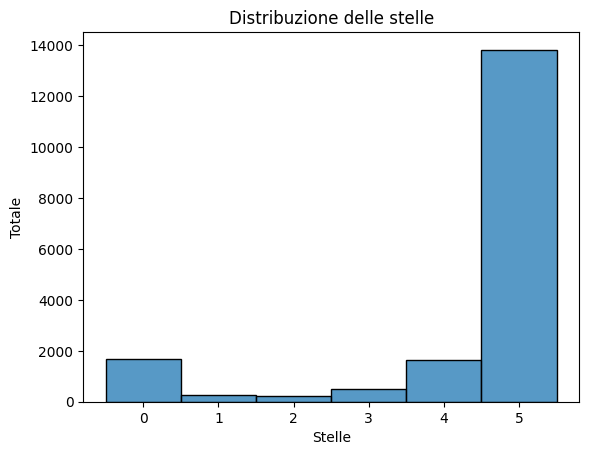

In [ ]:
plt.figure()
sns.histplot(df['stars'], bins=6, discrete=True)
plt.title("Distribuzione delle stelle")
plt.xlabel("Stelle")
plt.ylabel("Totale")
plt.show()

Questo tipo di sbilanciamento è tipico dei problemi in cui si ha a che fare con un rating dato dall'utente.

Studiamo adesso la correlazione tra le feature numeriche.

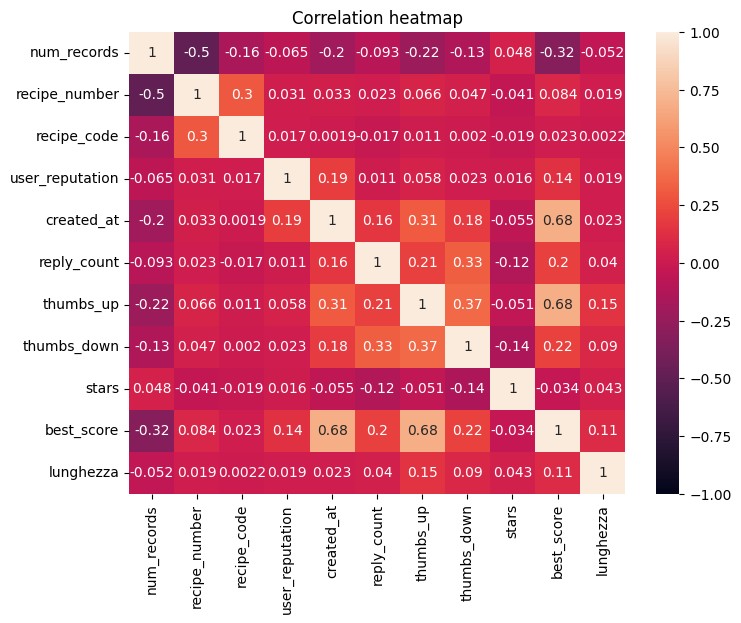

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlation heatmap')
plt.show()

Il numero di stelle sembra non essere correlato alle altre feature numeriche, però questi valori corroborano l'ipotesi che "best_score" sia il punteggio usato dal sito per decidere quali commenti mostrare più in alto. Ha infatti una correlazione positiva rilevante con "created_at" e "thumbs_up", e una correlazione minore ma non irrilevante con la reputazione dell'utente, il numero di risposte ricevute e il numero di pollici in giù.

# Preparazione dei dati

Innanzitutto, poiché useremo "stars" come indicatore del sentiment dell'utente, eliminiamo dal dataset i sample in cui "stars" è zero, il che indica che l'utente non ha lasciato un rating.

In [ ]:
# Eliminiamo dal dataframe i sample in cui le "stars" è uguale a 0
df = df[df["stars"] != 0]

# Verifichiamo le dimensioni del dataset
df.shape

(16486, 16)

Eliminiamo i due sample in cui il testo manca. Non abbiamo bisogno di usare una tecnica di imputazione, perché si tratta di un numero molto piccolo rispetto al numero totale di sample.

In [ ]:
# Eliminiamo i NaN
df = df.dropna(subset="text")

# Verifichiamo che ci siano solo due sample in meno e che non ci siano altri missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16484 entries, 0 to 18181
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   num_records      16484 non-null  int64 
 1   recipe_number    16484 non-null  int64 
 2   recipe_code      16484 non-null  int64 
 3   recipe_name      16484 non-null  object
 4   comment_id       16484 non-null  object
 5   user_id          16484 non-null  object
 6   user_name        16484 non-null  object
 7   user_reputation  16484 non-null  int64 
 8   created_at       16484 non-null  int64 
 9   reply_count      16484 non-null  int64 
 10  thumbs_up        16484 non-null  int64 
 11  thumbs_down      16484 non-null  int64 
 12  stars            16484 non-null  int64 
 13  best_score       16484 non-null  int64 
 14  text             16484 non-null  object
 15  lunghezza        16484 non-null  int64 
dtypes: int64(11), object(5)
memory usage: 2.1+ MB


# Definizione della baseline

Verifichiamo la performance di un modello naive che predice sempre e solo 5 stelle.

In [ ]:
# Creiamo un vettore di 5 lungo quanto il numero di sample presente nel dataset
pred = np.full(df.shape[0], 5)

# Vediamo il classification report
print(classification_report(df["stars"], pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       280
           2       0.00      0.00      0.00       232
           3       0.00      0.00      0.00       490
           4       0.00      0.00      0.00      1655
           5       0.84      1.00      0.91     13827

    accuracy                           0.84     16484
   macro avg       0.17      0.20      0.18     16484
weighted avg       0.70      0.84      0.77     16484



Questo è quello che ci aspettiamo da un dataset molto sbilanciato.

# Preparazione di training e test set

In [ ]:
# Definiamo design matrix e target variable
X = df["text"]
y = df["stars"]

Mettiamo da parte un test set. Utilizziamo stratify per fare in modo che i sample nel test set abbiano la stessa distribuzione di quelli nel training set.

In [ ]:
# Teniamo gli indici originali per poter risalire alle recensioni più avanti
df["original_index"] = df.index

X_train, X_test, y_train, y_test, X_train_indices, X_test_indices = train_test_split(X, y, df["original_index"], shuffle=True, test_size=0.2, random_state=42, stratify=y)

Verifichiamo le proprietà statistiche di questa split.

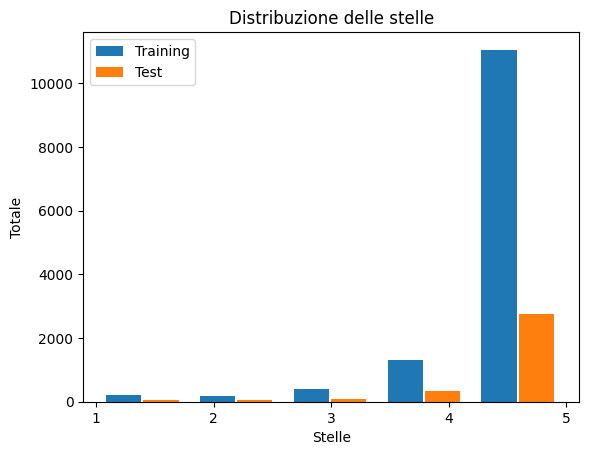

In [ ]:
# Conteggio delle stelle in training e test set
plt.figure()
plt.hist([y_train, y_test], bins=5, align='mid', width=0.3, label=['Training', 'Test'])
plt.xticks([1, 2, 3, 4, 5])
plt.title("Distribuzione delle stelle")
plt.xlabel("Stelle")
plt.ylabel("Totale")
plt.legend()
plt.show()

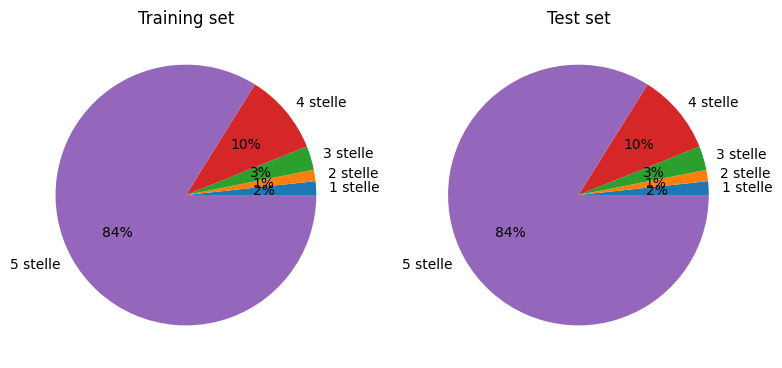

In [ ]:
# Percentuali
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
data1 = [y_train.value_counts(normalize=True)[i] for i in range(1,6)]
data2 = [y_test.value_counts(normalize=True)[i] for i in range(1,6)]
keys = [f'{i} stelle' for i in np.arange(1,6)]
axs[0].pie(data1, labels=keys, autopct='%.0f%%')
axs[0].set_title('Training set')

axs[1].pie(data2, labels=keys, autopct='%.0f%%')
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

# Model selection ed evaluation

Testeremo tre diversi modelli: Multinomial Naive Bayes, Complement Naive Bayes e Logistic Regression. Proveremo a usare sia CountVectorizer che TfidfVectorizer, con e senza n-grammi, e diverse tecniche di resampling: nessuna, RandomOverSampler e SMOTE.

Useremo Stratified K-fold per fare cross-validation, in quanto, a differenza del classico K-fold, preserva la percentuale di sample per ciascuna classe (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).

Come metrica useremo F1_macro, ossia una media **non ponderata** dell'F1 per ciascuna classe. Infatti, F1_weighted sarebbe più adatta se volessimo favorire la classe con più sample, mentre F1_micro ci dà un'idea dell'accuratezza del modello, e non tiene conto della performance sulle singole classi.

In [ ]:
# Modelli
mnb = MultinomialNB()
knn = KNeighborsClassifier()
models = {'MultinomialNB': mnb,
          'KNN': knn
          }

# Vectorizer
cv2 = CountVectorizer(ngram_range=(1,2))
tf2 = TfidfVectorizer(ngram_range=(1,2))
vecs = {'CountVectorizer': cv2,
        'TfidfVectorizer': tf2
        }

# Oversampler
ros = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)
samplers = {'None': None,
            'RandomOverSampler': ros,
            'SMOTE': smote
            }

# Parameter grid
p_grid = {mnb: {'model__alpha': [0.01, 0.5, 1, 2]},
          knn: {'model__k': [3, 5, 7, 9]}}



Creiamo una pipeline per fare in modo che tutti gli step di preprocessing siano fatti all'interno della cross-validation, evitando così data leakage.

Facciamo una cross-validation molto veloce, giusto per vedere quali modelli sono i più promettenti. Una cross-validation più sofisticata richiederebbe troppo tempo e risorse computazionali, e la riserveremo ai modelli migliori dopo la prima scrematura.

In [ ]:
results = []

for vec_name, vec in vecs.items():
  for samp_name, samp in samplers.items():
    for model_name, model in models.items():
      print(f'Processando modello {model_name} con sampler {samp_name} e vectorizer {vec_name}...')

      # Creiamo la pipeline
      steps = [('vectorizer', vec)]
      if samp is not None:
        steps.append(('sampler', samp))
      steps.append(('model', model))

      score = cross_val_score(ImbPipeline(steps), X_train, y_train, scoring='f1_macro')

      results.append({
          'Vectorizer': vec_name,
          'Sampler': samp_name,
          'Model': model_name,
          'F1 Macro Media': np.mean(score),
          'F1 Macro Std': np.std(score)
      })


Processando modello MultinomialNB con sampler None e vectorizer CountVectorizer...
Processando modello KNN con sampler None e vectorizer CountVectorizer...
Processando modello MultinomialNB con sampler RandomOverSampler e vectorizer CountVectorizer...
Processando modello KNN con sampler RandomOverSampler e vectorizer CountVectorizer...
Processando modello MultinomialNB con sampler SMOTE e vectorizer CountVectorizer...
Processando modello KNN con sampler SMOTE e vectorizer CountVectorizer...
Processando modello MultinomialNB con sampler None e vectorizer TfidfVectorizer...
Processando modello KNN con sampler None e vectorizer TfidfVectorizer...
Processando modello MultinomialNB con sampler RandomOverSampler e vectorizer TfidfVectorizer...
Processando modello KNN con sampler RandomOverSampler e vectorizer TfidfVectorizer...
Processando modello MultinomialNB con sampler SMOTE e vectorizer TfidfVectorizer...
Processando modello KNN con sampler SMOTE e vectorizer TfidfVectorizer...


In [ ]:
results_df = pd.DataFrame(results)
results_df.sort_values('F1 Macro Media', ascending=False)

,Vectorizer,Sampler,Model,F1 Macro Media,F1 Macro Std
10,TfidfVectorizer,SMOTE,MultinomialNB,0.415767,0.014580
8,TfidfVectorizer,RandomOverSampler,MultinomialNB,0.412168,0.017573
2,CountVectorizer,RandomOverSampler,MultinomialNB,0.396302,0.012492
4,CountVectorizer,SMOTE,MultinomialNB,0.317947,0.023109
3,CountVectorizer,RandomOverSampler,KNN,0.242252,0.009848
1,CountVectorizer,None,KNN,0.223339,0.012895
7,TfidfVectorizer,None,KNN,0.189376,0.006226
0,CountVectorizer,None,MultinomialNB,0.188480,0.001646
6,TfidfVectorizer,None,MultinomialNB,0.182465,0.000016
5,CountVectorizer,SMOTE,KNN,0.088107,0.004849


Usiamo una tecnica di cross-validation chiamata **nested cross-validation**, così da provare in modo più efficiente le varie combinazioni di iperparametri, sia generali sia del modello particolare.

Riferimento: https://scikit-learn.org/dev/auto_examples/model_selection/plot_nested_cross_validation_iris.html

In [ ]:
def nested_cross_val(n, config):
    print(f'Processando modello {config[2][1]} con sampler {config[1][1]} e vectorizer {config[0][1]}...')

    scores = []
    best_params =[]
    for i in range(n):
        outer_cv = StratifiedKFold(shuffle=True, random_state=i)
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=i+100)

        # Creiamo la pipeline
        pipeline = ImbPipeline(config)

        # Nested CV
        clf = GridSearchCV(estimator=pipeline, param_grid=p_grid[config[2][1]], cv=inner_cv, scoring='f1_macro')
        clf.fit(X_train, y_train)
        best_params.append(clf.best_params_)
        score = cross_val_score(clf, X_train, y_train, cv=outer_cv, scoring='f1_macro')
        scores.append(np.mean(score))

    return scores, best_params

Processando modello MultinomialNB() con sampler RandomOverSampler(random_state=42) e vectorizer TfidfVectorizer(ngram_range=(1, 2))...
Processando modello MultinomialNB() con sampler SMOTE(random_state=42) e vectorizer TfidfVectorizer(ngram_range=(1, 2))...


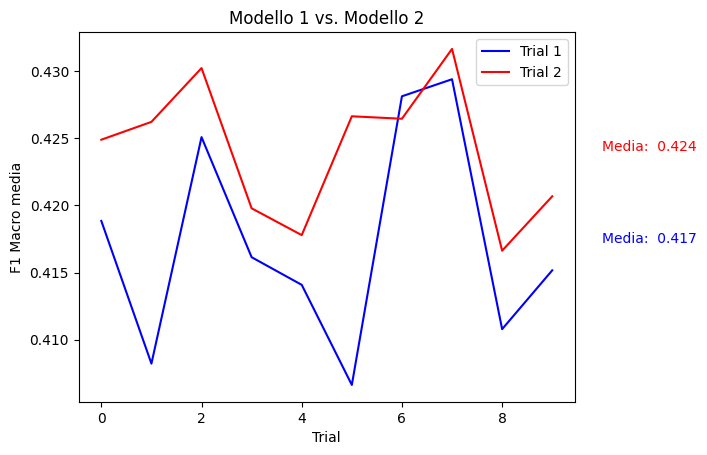

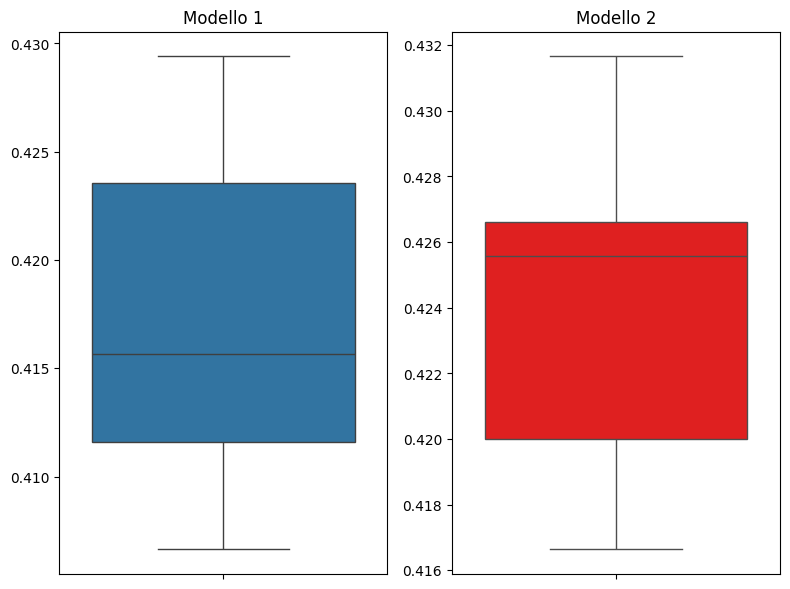

Trial 1: [{'model__alpha': 0.5}, {'model__alpha': 1}, {'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}]
Trial 2: [{'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}, {'model__alpha': 0.5}]


In [ ]:
NUM_TRIALS = 10

configs = [
    [('vectorizer', tf2),
     ('sampler', ros),
      ('model', mnb)
      ],
    [('vectorizer', tf2),
     ('sampler', smote),
     ('model', mnb)
     ]
    ]

trial1_score, trial1_best_params = nested_cross_val(NUM_TRIALS, configs[0])
trial2_score, trial2_best_params = nested_cross_val(NUM_TRIALS, configs[1])

# Confrontiamo la performance dei due modelli
plt.figure()
plt.plot(np.arange(NUM_TRIALS), trial1_score, label='Trial 1', color='blue')
plt.plot(np.arange(NUM_TRIALS), trial2_score, label='Trial 2', color='red')
plt.title('Modello 1 vs. Modello 2')
plt.xlabel('Trial')
plt.ylabel('F1 Macro media')
plt.legend()
plt.text(10, np.mean(trial1_score), s=f'Media: {np.mean(trial1_score): .3f}', color='blue')
plt.text(10, np.mean(trial2_score), s=f'Media: {np.mean(trial2_score): .3f}', color='red')
plt.show()

# Vediamo la variabilità
fig, axes = plt.subplots(1, 2, figsize=(8,6))

sns.boxplot(data=trial1_score, ax=axes[0])
axes[0].set_title('Modello 1')

sns.boxplot(data=trial2_score, ax=axes[1], color='red')
axes[1].set_title('Modello 2')

plt.tight_layout()
plt.show()

# Stampiamo i parametri migliori
print(f'Trial 1: {trial1_best_params}')
print(f'Trial 2: {trial2_best_params}')

In questo modo vediamo che la cross-validation "vanilla" aveva dato dei risultati leggermente diversi.

Nella maggior parte dei casi il parametro migliore scelto è 0.5. Usiamo questo come alpha del modello finale. Procediamo dunque con l'addestramento sull'intero training set e valutiamo poi la performance sul test set.

              precision    recall  f1-score   support

           1       0.41      0.43      0.42        56
           2       0.15      0.22      0.18        46
           3       0.27      0.31      0.29        98
           4       0.26      0.44      0.33       331
           5       0.93      0.85      0.89      2766

    accuracy                           0.77      3297
   macro avg       0.41      0.45      0.42      3297
weighted avg       0.83      0.77      0.80      3297



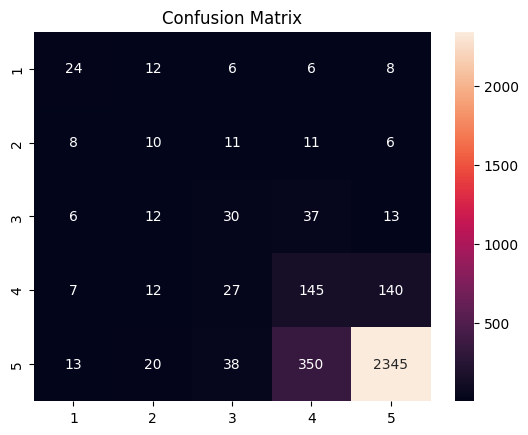

In [ ]:
final_pipeline = ImbPipeline([('vectorizer', tf2),
                              ('sampler', smote),
                              ('model', MultinomialNB(alpha=0.5))])

final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)

# Valutazione del modello finale
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', xticklabels=np.arange(1,6), yticklabels=np.arange(1,6))
plt.title('Confusion Matrix')
plt.show()

# Analisi degli errori

In [ ]:
# Identifica gli errori
error_indices = (y_test != y_pred)

# Filtra gli indici originali per gli errori
original_error_indices = X_test_indices[error_indices]

# Recupera i commenti originali e le relative informazioni
errors_df = pd.DataFrame({
    "Commento": df.loc[original_error_indices, "text"].values,
    "Valore Reale": y_test[error_indices].values,
    "Valore Predetto": y_pred[error_indices],
    "lunghezza": df.loc[original_error_indices, "lunghezza"].values
})

# Mostra i primi 100 errori
errors_df.head(100)

,Commento,Valore Reale,Valore Predetto,lunghezza
0,"Amazing! Frosting was very sweet, I added the entire 2 C of powdered sugar and I wish I would have added a little less. But these were fantastic!",4,2,145
1,"This is a fantastic dessert to feed a crowd. I was a bit skeptical of how thick my batter was to spread on the bottom of my pan, but it all baked up just fine! These cut best for me after chilling slightly. Delicious!",5,4,220
2,"This was delicious! My one piece of advice would be to make sure you cook it long enough!! For us the 45 minutes was not long enough. It tasted fine raw, but better when we cooked it long enough!! Thanks for the recipe!",5,4,223
3,My pies set up very well. I tried it with no-sugar red raspberry jello and reduced fat raspberry yogurt. It disappeared as fast as the key-lime pie.,4,5,150
4,Tasty.,3,4,6
...,...,...,...,...
95,"It doesn&#39;t look anything like the picture, but it&#39;s EXCELLENT!!",5,2,71
96,Great flavor. We&#39;ll be adding fresh jalapeno to the toppings next time for a little more kick!,5,4,98
97,"I made this last night with mahi mahi, and it was great! I&#39;ll try it again with tilapia, which I&#39;m sure will be great, also. I imagine this preparation would be good for any kind of fish fillets.",5,3,205
98,Yum. I cut back a little on the sugar and it was still plenty sweet.,5,4,68


Vediamo se gli errori sono in qualche modo correlati alla lunghezza della recensione.

In [ ]:
errors_df['lunghezza'].describe()

,lunghezza
count,831.000000
mean,200.398315
std,177.090614
min,1.000000
25%,78.500000
50%,157.000000
75%,266.500000
max,2065.000000


Dalla matrice di correlazione vediamo che la maggior parte degli errori consiste nello scambio di 4 e 5. Selezioniamo i commenti per cui è stato predetto 5, ma il vero valore era 4, e quelli per cui è stato predetto 4, ma il vero valore era 5.

In [ ]:
tipo1 = errors_df['Commento'].loc[(errors_df['Valore Reale'] == 4) & (errors_df['Valore Predetto'] == 5)]
tipo2 = errors_df['Commento'].loc[(errors_df['Valore Reale'] == 5) & (errors_df['Valore Predetto'] == 4)]

tipo1.head(10)

,Commento
3,My pies set up very well. I tried it with no-sugar red raspberry jello and reduced fat raspberry yogurt. It disappeared as fast as the key-lime pie.
5,"I saw this same salad in the Jewels Food Store Deli. Bought a half pound. Figured out simple ingredients, looked up recipe, found this one. Only difference is they added cheddar cheese, green and red pepper. I added 1/2 cup Cesar dressing, and little grlic powder. YUMMMM."
10,Excellent recipe and directions are easy to follow. My only suggestion is to have fun with the recipe and serve pickle relish and ketchup on the side. My guestsenjoyed the recipe and laughed. Made their evening!!
11,"My tongue is still tingling from my first piece, fresh out of the oven. HOT and yummy!Pros- moist and baked through. I was really worried about putting it all in one pan, because I hate partially cooked banana bread. This was banana bread, not pudding, and I liked very much. Great flavor. However, I did cut back on the sugar (only 3/4 cup brown and 1/4 cup white) and substituted applesauce for oil. Didn&#39;t have buttermilk onhand so I just used milk and put some butter in for flavor. My dd and I are more than happy with the result.Raised up to a beautiful loaf of bread. I don&#39;t know if it helped that I whisked the banana and egg mixture with an electric beater to be sure I didn&#39;t have banana globs. I will continue to do that.Cons- considering how sweet it is, I would not follow the recipe sugar recommendation.Bake time for my loaf was too long, and I only had it in for 50 minutes. I was glad it was baked through, but if this had been for gifts, I would not have shared. The ends will be way too tough and overdone. It is very tough about a half to an inch around. If I would have gone the full 1 hr 20 minutes it would have been like a gummy bear.Overall, love it. Going back for my second slice now!"
15,very simple and easy to bake
19,"Pretty good, but make sure to use a 12&#34; skillet. I also recommend changing the last step. I used a cast iron skillet, &amp; after adding the cheese, I put it under the broiler for a couple of minutes."
22,"I made this recipe a few times for guest, everyone loves it. Very rich but well worth it."
26,Having company for a week. Any chance this one freezes well?
50,This was my first attempt at making fish. I don&#39;t eat fish often but am trying to start eating more of it. I chose this recipe because of ease of preparation and its use of capers (I love them!). It really was a very easy preparation. The result was great! The combination of lemon with the spices was very fresh-tasting and the paprika gave it just enough of a smoky flavor. I will definitely be making this again!
56,Great recipe ?? we used carb master yogurt to cut the carbs ? my daughter is a type 1 diabetic so we gotta watch those ?? anybody knocking this recipe or anything sugar free !!! Some people aren&#39;t as fortunate or have no choice with certain things ???? my daughter can still consume sugars etc and to be honest white bread would spike her more then a snicker bar lol contrary to belief...


In [ ]:
tipo2.head(10)

,Commento
1,"This is a fantastic dessert to feed a crowd. I was a bit skeptical of how thick my batter was to spread on the bottom of my pan, but it all baked up just fine! These cut best for me after chilling slightly. Delicious!"
2,"This was delicious! My one piece of advice would be to make sure you cook it long enough!! For us the 45 minutes was not long enough. It tasted fine raw, but better when we cooked it long enough!! Thanks for the recipe!"
8,"This was so dang good, but have to say we changed it up a bit b/c we thought it might be a bit bland for us. Added 3/4 lb hot Italian sausage, 5 mushrooms, replaced the water w/ low sodium beef broth, used tomato paste w/ basil, garlic &amp; oregano, added 1+ tsp each dried oregano, basil &amp; Italian seasoning, 1/8 tsp each red pepper flakes and cayenne pepper, and added 1 c Italian shredded 5 cheeses. Next time will use a crock liner to make removing it easier. Really great the next day too, lots of flavor!"
9,"My first rhubarb dessert for this season, the crust and the filling were wonderful! The topping was good but there was way too much of it. I only put half of it on and it was still over powering. One package of cream cheese would have been plenty. Family suggested we just use cool whip next time so we could taste the rhubarb. I will make again. Thanks for the recipe."
12,Made these and they are more of a ginger snap taste than a gingerbread but that was fine with us! Very easy. 2nd batch seemed a little dry to roll but added a little more butter and it came out easier to roll. Definitely will make again!
14,"It&#39;s so good, but even better with home canned broth (less salt) and homegrown tomatoes stewed and canned."
18,LOVE LOVE LOVE! I cut the sugar back to 1 cup and the confectioners sugar to 3 cups - turned out delicious. Next time I&#39;d cut the sugar in the frosting in half - that would be sweet enough. This one&#39;s a keeper.
20,"This was delicious, I was feeling creative so I made some modifications. I added a few splashes of white wine for flavour, sautéed some garlic and onion in with the mushrooms . I also added some season salt to the flour mix. Served with asparagus and dill cream sauce...YUMMY!My boyfriend gave it a 9/10 and said that I need to &#34;remember this one&#34;"
21,"This is a very yummy and quick soup to make usually have all the stuff on hand! My only changes were to brown the beef w/the green peppers and added onions, celery and garlic (as i just love those flavors in soup) and substituted beef broth for the water and bouillon and added 1 extra cup of rice. MMMMMMM"
27,"Absolutely delicous! It was a hit with everyone. I made it as the the recipe stated and it was great. We liked the chewy, crispy topping but would have liked more of it. I will double that part when I make it again."


Vediamo adesso gli errori più gravi, ossia quelli in cui un 1 è stato predetto come 5 e viceversa.

In [ ]:
tipo3 = errors_df['Commento'].loc[(errors_df['Valore Reale'] == 1) & (errors_df['Valore Predetto'] == 5)]
tipo4 = errors_df['Commento'].loc[(errors_df['Valore Reale'] == 5) & (errors_df['Valore Predetto'] == 1)]

tipo3.head(10)

,Commento
66,Honestly....this was truly the grossest soup I’ve ever made and I was so excited
199,There are much better white bread recipes out there. Recipes that use milk rather than water make a much better bread that is easier to slice and use for sandwiches. Disappointing.
302,I love it it is the BEST SOUP EVER that is why i gave it one star


In [ ]:
tipo4.head(10)

,Commento
6,Followed recipe exactly &amp; is delicious.
23,I love the recipe as is. It does need to bake a bit longer than in the recipe but of is not &#34;eggy&#34; at all. I really hate egg. This recipe is really good but rich.
125,"I have a ton of apples and decided to make Apple pie. I’ve always heard Granny Smith apples make the best pies. It turns out it’s because tart apples have the most pectin and other apples can make your pie soupy. Lesson learned... either use Granny Smith or allow apples to macerate and release juices prior to baking. Watery or not, the pie was still delicious!"
130,"If I could give this 10 stars I would! My cakes turn out just like the picture and are absolutely wonderful!! Because it is loaded with calories, I save this for very special occasions!"
158,
264,This recipe is fantastic!
309,expellant recipe
394,Perfect! There is a reason so many people have given this recipe 5 stars.
415,"Absolutely wonderful. I didn&#39;t have dry mustard, so I substituted a gourmet mustard instead. I kept an eye an it, so that it didn&#39;t come out too dry. It was in the oven for about 25 minutes."
471,"I enjoys these reviews. Rarely make the recipes. Jaw-dropping amazing how mean some of these reviews are. That someone would sign in and go out of their way to tell someone “learn to cook”, “ this was terrible”, what’s wrong with you people, this is a recipe site! Why do you have to be infect your personality onto this nice place by being jerks?"


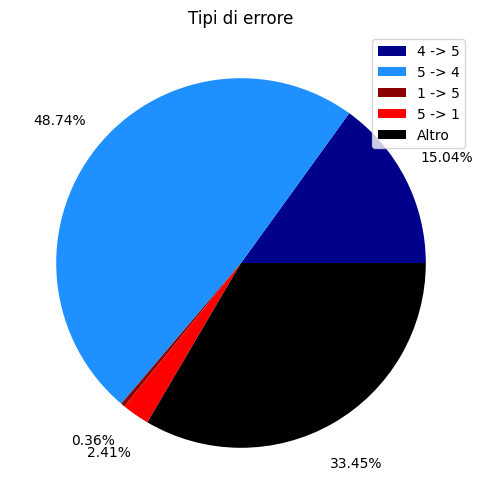

In [ ]:
# Visualizziamo quanti sono gli errori dei quattro tipi visti sopra rispetto al totale
tot = len(errors_df)
perc = [(len(tipo)/tot * 100) for tipo in [tipo1, tipo2, tipo3, tipo4]]
perc.append(100 - np.sum(perc))
keys = ['4 -> 5', '5 -> 4', '1 -> 5', '5 -> 1', 'Altro']
colors = ['DarkBlue', 'DodgerBlue', 'DarkRed', 'Red', 'Black']

plt.figure(figsize=(8,6))
plt.pie(perc, autopct='%.2f%%', pctdistance=1.25, colors=colors)
plt.legend(keys)
plt.title('Tipi di errore')
plt.show()